In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/11wdsad/test.png


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}.')

Training on device: cuda.


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
#    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
#    transforms.RandomCrop(24, padding=4),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

for data, target in train_loader:
    data, target = data.to(device), target.to(device)
for data, target in test_loader:
    data, target = data.to(device), target.to(device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14529590.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 465022.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4332190.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2270082.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



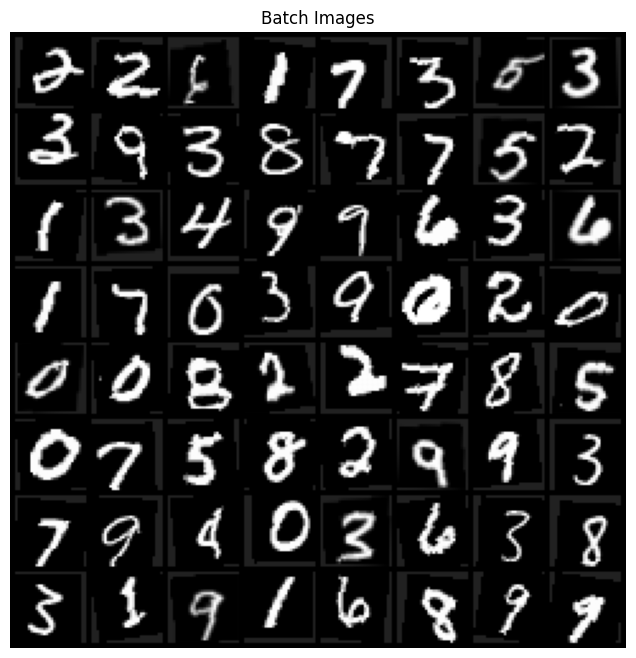

In [4]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
def show_batch_images(dataloader, mean, std):
    # 从 dataloader 中获取一批数据
    images, labels = next(iter(dataloader))



    # 反标准化
    images = images * torch.tensor(std).view(1, 1, 1, 1) + torch.tensor(mean).view(1, 1, 1, 1)

    # 绘制图像网格
    plt.figure(figsize=(8, 8))  # 调整显示大小
    grid = vutils.make_grid(images, nrow=int(len(images)**0.5), normalize=True)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title("Batch Images")
    plt.axis('off')  # 不显示坐标轴
    plt.show()
    
    
show_batch_images(train_loader, 0.1307, 0.3081)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.4),
            
            # Second Convolution Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.4)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 128),  # Adjust the input features to match the output from the last Conv2d
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = CNN().to(device)


In [6]:
def train_model(model, train_loader, test_loader, criterion, optimizer, history, num_epochs=10, device='cuda'):
    
    # 将模型移到设备上
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  # 训练模式
        train_loss, train_correct, train_total = 0, 0, 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            train_correct += (predicted == target).sum().item()
            train_total += target.size(0)
        
        train_acc = 100 * train_correct / train_total
        train_loss /= train_total
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        
        model.eval()  # 评估模式
        test_loss, test_correct, test_total = 0, 0, 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                test_correct += (predicted == target).sum().item()
                test_total += target.size(0)
        
        test_acc = 100 * test_correct / test_total
        test_loss /= test_total
        history['test_acc'].append(test_acc)
        history['test_loss'].append(test_loss)
        
        # 打印每个epoch的结果
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%')
        
        # 保存模型
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
    
    return history

In [7]:
history = {
        'train_acc': [],
        'train_loss': [],
        'test_acc': [],
        'test_loss': []
    }
# 实例化模型、损失函数和优化器
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

history = train_model(model, train_loader, test_loader, criterion, optimizer, history, num_epochs=40)

Epoch 1/40
Train Loss: 0.2346 Acc: 92.88%
Test Loss: 0.0472 Acc: 98.49%
Epoch 2/40
Train Loss: 0.0881 Acc: 97.36%
Test Loss: 0.0236 Acc: 99.26%
Epoch 3/40
Train Loss: 0.0688 Acc: 97.97%
Test Loss: 0.0212 Acc: 99.31%
Epoch 4/40
Train Loss: 0.0608 Acc: 98.22%
Test Loss: 0.0254 Acc: 99.20%
Epoch 5/40
Train Loss: 0.0561 Acc: 98.27%
Test Loss: 0.0181 Acc: 99.43%
Epoch 6/40
Train Loss: 0.0524 Acc: 98.44%
Test Loss: 0.0169 Acc: 99.40%
Epoch 7/40
Train Loss: 0.0464 Acc: 98.61%
Test Loss: 0.0187 Acc: 99.38%
Epoch 8/40
Train Loss: 0.0442 Acc: 98.68%
Test Loss: 0.0169 Acc: 99.43%
Epoch 9/40
Train Loss: 0.0400 Acc: 98.78%
Test Loss: 0.0168 Acc: 99.49%
Epoch 10/40
Train Loss: 0.0377 Acc: 98.85%
Test Loss: 0.0167 Acc: 99.51%
Epoch 11/40
Train Loss: 0.0370 Acc: 98.85%
Test Loss: 0.0116 Acc: 99.62%
Epoch 12/40
Train Loss: 0.0348 Acc: 98.94%
Test Loss: 0.0144 Acc: 99.56%
Epoch 13/40
Train Loss: 0.0333 Acc: 98.94%
Test Loss: 0.0152 Acc: 99.52%
Epoch 14/40
Train Loss: 0.0316 Acc: 99.03%
Test Loss: 0.0120

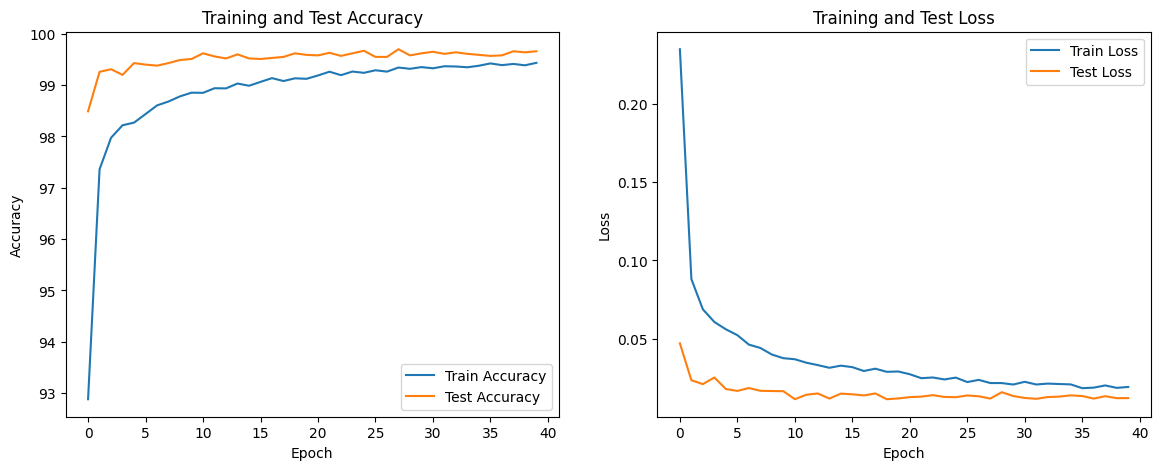

In [8]:
def plot_history(history):
    # 创建一个图形窗口
    plt.figure(figsize=(14, 5))
    
    # 绘制准确率历史
    plt.subplot(1, 2, 1)  # 1行2列的第1个
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 绘制损失历史
    plt.subplot(1, 2, 2)  # 1行2列的第2个
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 显示图表
    plt.show()

# 调用函数来绘制图表
plot_history(history)

In [9]:
np.array(history['train_acc']).argmax()

39